# Sztuczna inteligencja i inżynieria wiedzy, Lista 1
_Wojciech Krzos, 276264, grupa 5_

## Wstęp
### Cel laboratorium

Celem laboratorium jest praktyczne zapoznanie się z problemami optymalizacyjnymi oraz zastosowanie metod rozwiązywania tych problemów omawianych na wykładzie. W ramach laboratorium zostały zaimplementowane algorytmy wyszukiwania optymalnej trasy w komunikacji miejskiej, z uwzględnieniem dwóch kryteriów optymalizacyjnych: minimalizacji czasu podróży lub minimalizacji liczby przesiadek.

### Źródło danych

Dane wykorzystane w projekcie pochodzą z portalu https://opendata.cui.wroclaw.pl/dataset/rozkladjazdytransportupublicznegoplik_data, który udostępnia rozkłady jazdy transportu publicznego we Wrocławiu. Plik `connection_graph.csv` zawiera 996,520 rekordów połączeń komunikacyjnych o następującej strukturze:

| Kolumna | Opis |
|---------|------|
| company | Przewoźnik (np. MPK Autobusy) |
| line | Numer linii (np. A, 1, 125) |
| departure_time | Czas odjazdu (format HH:MM:SS) |
| arrival_time | Czas przyjazdu (format HH:MM:SS) |
| start_stop | Nazwa przystanku początkowego |
| end_stop | Nazwa przystanku końcowego |
| start_stop_lat | Szerokość geograficzna przystanku początkowego |
| start_stop_lon | Długość geograficzna przystanku początkowego |
| end_stop_lat | Szerokość geograficzna przystanku końcowego |
| end_stop_lon | Długość geograficzna przystanku końcowego |

Przykładowy fragment danych:

| company | line | departure_time | arrival_time | start_stop | end_stop | start_stop_lat | start_stop_lon | end_stop_lat | end_stop_lon |
|---------|------|----------------|--------------|------------|----------|----------------|----------------|--------------|------------|
| MPK Autobusy | A | 20:52:00 | 20:53:00 | Zajezdnia Obornicka | Paprotna | 51.14873744 | 17.02106859 | 51.14775215 | 17.02053929 |
| MPK Autobusy | A | 20:53:00 | 20:54:00 | Paprotna | Obornicka (Wołowska) | 51.14775215 | 17.02053929 | 51.144385 | 17.023735 |
| MPK Autobusy | A | 20:54:00 | 20:55:00 | Obornicka (Wołowska) | Bezpieczna | 51.144385 | 17.023735 | 51.14136001 | 17.02637623 |

### Zastosowania

Algorytmy omawiane w ramach listy mają wachlarz zastosowań, natomiast skupiając się na tematyce laboratorium, możemy znaleźć ich implementację w m.in.:

1. **Jakdojade:** aplikacja do wyszukiwania połączeń komunikacji miejskiej w Polsce, która znajduje i udostępnia użytkownikowi zbiór optymalnych tras pomiędzy wybranymi przystankami.

2. **Google Maps:** wykorzystuje zaawansowane wersje algorytmów Dijkstra i A* do planowania podróży transportem publicznym, uwzględniając aktualne opóźnienia i utrudnienia. Dodatkowo, pozwala na znajdowanie tras: pieszym, rowerzystom, kierowcom aut osobowych i ciężarowych. W przeciwieństwie do Jakdojade, łączy ze sobą różne środk transportu jak kolej, lotnictwo, metro, długo-dystansowe tranzyty (np. Flixbux), a nawet promy.

Główna różnica między zaimplementowanymi algorytmami:

- **Dijkstra/A*** - Służą do znajdowania optymalnej trasy między dwoma punktami.
- **Tabu Search** - Jest wykorzystywany do rozwiązywania bardziej złożonego problemu, tj. znajdowania optymalnej trasy przez wiele przystanków (podobnego do problemu komiwojażera), który jest problemem NP-trudnym.

## Użyte biblioteki i uwagi technologiczne

Użyto środowiska wirtualnego Python. Wszystkie zależności skryptów znajdują się w `requirements.txt`.

W projekcie wykorzystano następujące biblioteki, które można podzielić na dwie grupy: biblioteki Python i biblioteki zewnętrzne.

**Biblioteki Python:**
1. **sys** - Zapewnia dostęp do zmiennych i funkcji związanych z interpreterem. Została użyta do obsługi argumentów wejściowych komend.

2. **time** - W projekcie wykorzystywana do mierzenia czasu wykonania algorytmów.

3. **argparse** - Służy do parsowania argumentów linii poleceń.

4. **os.path** - Służy do manipulacji ścieżkami plików. Użyta m.in. do odczytywania pliku connection_graph.csv oraz serializacji grafu za pomocą biblioteki pickle (patrz bilioteka 8 poniżej). 

5. **datetime.timedelta** - Klasa z modułu datetime do reprezentowania różnic czasowych. W projekcie używana do konwersji sekund na format godzinowy.

6. **math** - Używana do funkcji matematycznych w obliczeniach odległości geograficznych (w Dijkstra oraz A*) oraz do funkcji log w dynamicznym dostosowaniu rozmiaru listy tabu.

7. **random** - Biblioteka do generowania liczb pseudolosowych. Używana w algorytmie Tabu Search do generowania początkowych rozwiązań i dywersyfikacji przeszukiwania.

**Biblioteki zewnętrzne:**

8. **pandas** - Biblioteka analizy danych, używana do wczytywania i obróbki danych z plików CSV. Wykorzystywana głównie w module data_loader.py.

9. **pickle** - Moduł Pythona do serializacji i deserializacji obiektów. Używany do zapisywania i wczytywania struktury grafu, co pozwala na szybszy start programu przy kolejnych uruchomieniach (pozwoliło to na zaoszczędzenie ok. 90 sekund przy każdym uruchomieniu).

10. **collections.defaultdict** - Dostarcza domyślne wartości dla nieistniejących kluczy. Używane do reprezentacji grafu. Przy tworzeniu grafu nie musimy dzięki temu srpawdzać za każdym razem, czy klucz już istnieje.

11. **heapq** - Implementacja kolejki priorytetowej. Zwiększa efektywność algorytmu A*, gdzie potrzebujemy efektywnie wybierać wierzchołek o najmniejszym koszcie.


## Implementacje Dijkstra oraz A*

### Krótki wstęp
Program przyjmuje na wejściu 4 zmienne: (a) przystanek początkowy A, (b) przystanek końcowy B, (c) kryterium optymalizacyjne (t - minimalizacja czasu, p - minimalizacja liczby zmian linii) oraz (d) czas pojawienia się na przystanku.

Użyta została wcześniej wspomniana biblioteka argparse, dzięki której stworzona została komenda:
```
usage: main.py [-h] [--rebuild] start_stop target_stop {t,p} start_time
```

Oprócz wejściowych argumentów, dodano również opcję wyboru optymalziacji względem czasu (flaga t) lub względem przesiadek (flaga p).

Opcja `--rebuild` pozwala na ponowne zbudowanie grafu, a następnie na jego serializację do pliku `transit_graph.py`.



## Zadanie 1: Implementacja algorytmu Dijkstra oraz A*

**UWAGA:** Z racji na strukturę kodu (znajdującego się w załączniku) przedstawione są jedynie jego wycinki. Omawiamy kod znajduje się w folderach `dir` oraz `common`. Pomimo zamieszczenia fragmentów kodu poniżej, zalecane jest bezpośrednie spojrzenie na kod, który został odpowednio skomentowany.
 
### (a) Algorytm wyszukiwania najkrótszej ścieżki z A do B za pomocą algorytmu Dijkstry w oparciu o kryterium czasu

Poniższy fragment kodu implementuje algorytm Dijkstry, który jest wykorzystywany w A* (bez heurystyki) do znajdowania najkrótszej ścieżki między dwoma przystankami. W tym przypadku funkcja kosztu jest oparta na czasie podróży.

In [ ]:
# Fragment implementacji algorytmu Dijkstry (podstawa A* bez heurystyki)
def find_path_dijkstra(self, start, target, start_time, cost_criterion='t'):
    # Quick validation - check if target exists
    if target not in self.stops_coords:
        return None, float('inf')
        
    # Check if start and target are the same
    if start == target:
        return [], 0
        
    # Check if target is potentially reachable from start
    if not self.is_potentially_reachable(start, target):
        return None, float('inf')
    
    # Try to find direct connections first
    direct_result = self.find_direct_connections(start, target, start_time)
    if direct_result:
        return direct_result
    
    # If no direct path, use Dijkstra search
    visited = set()
    costs = {start: start_time}
    
    # Use priority queue for Dijkstra search
    pq = [(start_time, start, start_time, [], None)]
    
    while pq:
        g, current, curr_time, path, current_line = heapq.heappop(pq)
        
        # Skip if we've found a better path to this node
        if current in visited and costs[current] <= g:
            continue
            
        visited.add(current)
        costs[current] = g
        
        if current == target:
            return path, g
        
        # Explore outgoing edges
        for edge in sorted(self.graph.get(current, []), key=lambda e: e['dep_sec']):
            if edge['dep_sec'] >= curr_time:
                next_stop = edge['end_stop']
                
                # Skip already visited stops with better costs
                if next_stop in costs and costs[next_stop] <= g:
                    continue
                
                # Calculate cost based on criterion
                if cost_criterion == 't':
                    wait_time = edge['dep_sec'] - curr_time
                    ride_time = edge['arr_sec'] - edge['dep_sec']
                    step_cost = wait_time + ride_time
                else:  # cost_criterion == 'p'
                    step_cost = 0 if (current_line == edge['line']) or (current_line is None) else 1
                
                new_g = g + step_cost
                new_time = edge['arr_sec']
                
                # Skip if this makes the path too costly
                if next_stop in costs and costs[next_stop] <= new_g:
                    continue
                
                # Create path and add to queue
                new_path = path + [(edge['line'], current, edge['dep_sec'], next_stop, edge['arr_sec'])]
                heapq.heappush(pq, (new_g, next_stop, new_time, new_path, edge['line']))
    
    return None, float('inf')

### (b) Algorytm wyszukiwania najkrótszej ścieżki z A do B za pomocą algorytmu A* w oparciu o kryterium czasu

Poniższy fragment kodu prezentuje implementację algorytmu A* optymalizującego czas podróży. W porównaniu do Dijkstry, A* wykorzystuje funkcję heurystyczną, która szacuje pozostały czas do celu, co pozwala na bardziej efektywne przeszukiwanie grafu.

In [ ]:
# Funkcja heurystyczna dla optymalizacji czasu
def heuristic_time(self, current_stop, target_stop):
    """Heuristic function for travel time estimation."""
    MAX_SPEED_KM_S = 40/3600  # 40 km/h converted to km/s
    
    if current_stop not in self.stops_coords or target_stop not in self.stops_coords:
        return 0
        
    lat1, lon1 = self.stops_coords[current_stop]
    lat2, lon2 = self.stops_coords[target_stop]
    
    distance = haversine(lat1, lon1, lat2, lon2)
    return distance / MAX_SPEED_KM_S

In [ ]:
# Główna część algorytmu A* - optymalizacja czasu
# Fragment z funkcji find_path_a_star gdzie cost_criterion == 't'

# Kluczowy fragment obliczania kosztu dla kryterium czasu
if cost_criterion == 't':
    wait_time = edge['dep_sec'] - curr_time
    ride_time = edge['arr_sec'] - edge['dep_sec']
    step_cost = wait_time + ride_time
    
    # ...
    
    # Obliczanie heurystyki dla czasu
    h = self.heuristic_time(next_stop, target) * 1.2  # Slightly more aggressive heuristic
    
    # Dodanie do kolejki priorytetowej z kosztem f = g + h
    heapq.heappush(pq, (new_g + h, new_g, next_stop, new_time, new_path, edge['line']))

### (c) Algorytm wyszukiwania najkrótszej ścieżki z A do B za pomocą algorytmu A* w oparciu o kryterium przesiadek

Poniższy fragment kodu prezentuje implementację algorytmu A* optymalizującego liczbę przesiadek. W tym przypadku funkcja kosztu liczy przesiadki, a nie czas podróży.

In [ ]:
# Funkcja heurystyczna dla optymalizacji przesiadek
def heuristic_transfers(self, current_stop, target_stop):
    """Heuristic function for transfers minimization."""
    return 0  # Najprostsza heurystyka dla przesiadek

In [ ]:
# Główna część algorytmu A* - optymalizacja przesiadek
# Fragment z funkcji find_path_a_star gdzie cost_criterion == 'p'

# Kluczowy fragment obliczania kosztu dla kryterium przesiadek
else:  # cost_criterion == 'p'
    step_cost = 0 if (current_line == edge['line']) or (current_line is None) else 1
    
    # ...
    
    # Obliczanie heurystyki dla przesiadek
    h = self.heuristic_transfers(next_stop, target)
    
    # Dodanie do kolejki priorytetowej z kosztem f = g + h
    heapq.heappush(pq, (new_g + h, new_g, next_stop, new_time, new_path, edge['line']))

### (d) Modyfikacje algorytmu A* pozwalające na zmniejszenie wartości funkcji kosztu uzyskanego rozwiązania lub czasu obliczeń

Poniżej przedstawiono kilka kluczowych optymalizacji zastosowanych w algorytmie A*, które znacząco poprawiają jego wydajność.

In [ ]:
# 1. Wczesne wykrywanie bezpośrednich połączeń
def find_direct_connections(self, start, target, start_time):
    """Find direct connections between start and target after start_time."""
    direct_paths = []
    
    if not self.is_potentially_reachable(start, target):
        return None
        
    for edge in self.graph.get(start, []):
        if edge['end_stop'] == target and edge['dep_sec'] >= start_time:
            path = [(edge['line'], start, edge['dep_sec'], target, edge['arr_sec'])]
            cost = edge['arr_sec'] - start_time  # Total time including waiting
            direct_paths.append((path, cost))
            
    if direct_paths:
        # Return the direct path with minimum cost
        return min(direct_paths, key=lambda x: x[1])
    return None

In [ ]:
# 2. Wstępne obliczanie osiągalności (redukcja przestrzeni przeszukiwania)
def _precompute_reachability(self, all_stops):
    """Build a reachability map to quickly determine if a path might exist."""
    self.reachable_from = defaultdict(set)
    
    # Initialize with direct connections
    for start, end in self.direct_connections:
        self.reachable_from[start].add(end)
    
    # Use Floyd-Warshall like approach to expand reachability
    for intermediate in all_stops:
        for start in all_stops:
            if intermediate in self.reachable_from[start]:
                for end in self.reachable_from[intermediate]:
                    self.reachable_from[start].add(end)

In [ ]:
# 3. Przestrzenne przycinanie (spatial pruning)
def _is_too_far_from_path(self, current, next_stop, target, max_distance):
    """Check if next_stop is too far from the general path direction."""
    current_lat, current_lon = self.stops_coords[current]
    next_lat, next_lon = self.stops_coords[next_stop]
    target_lat, target_lon = self.stops_coords[target]
    
    # Calculate current distance to target
    current_to_target = haversine(current_lat, current_lon, target_lat, target_lon)
    
    # Calculate next stop distance to target
    next_to_target = haversine(next_lat, next_lon, target_lat, target_lon)
    
    # If next stop takes us away from target by more than the threshold, skip it
    if next_to_target > current_to_target * 1.5 and next_to_target > max_distance:
        return True
        
    return False

In [ ]:
# 4. Dynamiczne dostosowanie granicy przeszukiwania
# Fragment z find_path_a_star

# Calculate spatial bounds for pruning
if start in self.stops_coords and target in self.stops_coords:
    start_lat, start_lon = self.stops_coords[start]
    target_lat, target_lon = self.stops_coords[target]
    max_distance = haversine(start_lat, start_lon, target_lat, target_lon) * 2.5  # Allow 2.5x the direct distance
else:
    max_distance = float('inf')

# ...

# Dynamic bound adjustment - if we're exploring too widely, tighten the bound
if nodes_explored > 5000:
    max_distance *= 0.8

In [ ]:
# 5. Serializacja grafu do szybkiego ponownego użycia
def save_to_file(self, filename):
    """Serialize the transit graph to a file."""
    try:
        with open(filename, 'wb') as f:
            pickle.dump({
                'graph': self.graph,
                'stops_coords': self.stops_coords,
                'direct_connections': self.direct_connections,
                'reachable_from': self.reachable_from
            }, f)
        return True
    except Exception as e:
        print(f"Error saving graph: {e}")
        return False

@classmethod
def load_from_file(cls, filename):
    """Load a transit graph from a serialized file."""
    try:
        graph = cls()
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            graph.graph = data['graph']
            graph.stops_coords = data['stops_coords']
            graph.direct_connections = data['direct_connections']
            graph.reachable_from = data['reachable_from']
        return graph
    except Exception as e:
        print(f"Error loading graph: {e}")
        return None

## Zadanie 2: Implementacja algorytmu przeszukiwania opartego na przeszukiwaniu Tabu

### (a) Algorytm rozwiązujący problem odwiedzenia wierzchołków oparty na przeszukiwaniu Tabu bez ograniczenia na rozmiar tablicy T

Poniżej przedstawiona jest implementacja bazowego przeszukiwania Tabu. Algorytm ten rozwiązuje problem odwiedzenia zbioru przystanków w optymalnej kolejności. Bazowa wersja przechowuje historię wszystkich odwiedzonych rozwiązań w tablicy tabu, bez ograniczeń na jej rozmiar.

In [ ]:
# Podstawowa klasa TabuSearch bez ograniczeń na rozmiar listy tabu
class BasicTabuSearch(TabuRouting):
    """Basic Tabu Search implementation without limitation on tabu list size."""
    
    def run_tabu_search(self):
        """Run the Tabu Search algorithm."""
        # Generate initial solution
        current_solution = self.generate_initial_solution()
        
        # Evaluate initial solution
        current_path, current_cost = self.evaluate_solution(current_solution)
        
        # Initialize best solution
        self.best_solution = current_solution
        self.best_cost = current_cost
        best_path = current_path
        
        # Main Tabu Search loop
        iterations_without_improvement = 0
        for iteration in range(self.max_iterations):
            # Generate neighbors
            neighbors = self.get_neighbors(current_solution)
            
            # Evaluate neighbors and choose the best non-tabu neighbor
            best_neighbor = None
            best_neighbor_cost = float('inf')
            best_neighbor_path = None
            
            for neighbor in neighbors:
                if not self.is_tabu(neighbor):
                    path, cost = self.evaluate_solution(neighbor)
                    if cost < best_neighbor_cost:
                        best_neighbor = neighbor
                        best_neighbor_cost = cost
                        best_neighbor_path = path
            
            # If no non-tabu neighbor was found, break
            if best_neighbor is None:
                break
            
            # Update current solution
            current_solution = best_neighbor
            current_cost = best_neighbor_cost
            current_path = best_neighbor_path
            
            # Add the neighbor to the tabu list
            self.tabu_list.append(best_neighbor)
            
            # Update best solution if necessary
            if current_cost < self.best_cost:
                self.best_solution = current_solution
                self.best_cost = current_cost
                best_path = current_path
                iterations_without_improvement = 0
            else:
                iterations_without_improvement += 1
            
            # Stop if no improvement for a while
            if iterations_without_improvement > 20:
                break
            
            sys.stderr.write(f"Iteration {iteration}: Best cost = {self.best_cost}\n")
        
        return best_path, self.best_cost

In [ ]:
# Funkcje pomocnicze z klasy TabuRouting służące do obsługi rozwiązań i sąsiedztwa
def generate_initial_solution(self):
    """Generate an initial solution (random permutation of stops)"""
    initial_solution = list(self.stops_to_visit)
    random.shuffle(initial_solution)
    return initial_solution

def evaluate_solution(self, solution):
    """Evaluate the cost of a solution by finding paths between consecutive stops."""
    complete_path = []
    total_cost = 0
    current_time = self.start_time
    current_stop = self.start_stop
    
    # Visit all stops in the solution
    for next_stop in solution:
        # Find path from current stop to next stop
        path, cost = self.graph.find_path_a_star(
            current_stop, next_stop, current_time, cost_criterion=self.criterion
        )
        
        if path is None:
            # If no path found, return infinite cost
            return None, float('inf')
        
        complete_path.extend(path)
        total_cost += cost
        
        # Update current stop and time for next iteration
        current_stop = next_stop
        if path:
            current_time = path[-1][4]  # Arrival time at the last stop
    
    # Return to the starting stop
    path, cost = self.graph.find_path_a_star(
        current_stop, self.start_stop, current_time, cost_criterion=self.criterion
    )
    
    if path is None:
        return None, float('inf')
    
    complete_path.extend(path)
    total_cost += cost
    
    return complete_path, total_cost

### (b) Modyfikacja algorytmu Tabu Search o dobór długości tablicy T w zależności od długości listy L w celu minimalizacji funkcji kosztu

Poniższa implementacja wprowadza dynamiczny dobór rozmiaru tablicy tabu w zależności od liczby przystanków do odwiedzenia. Pozwala to na lepsze zbalansowanie między eksploracją a eksploatacją przestrzeni rozwiązań.

In [ ]:
# Funkcja obliczająca optymalny rozmiar listy tabu na podstawie rozmiaru problemu
def _calculate_tabu_list_size(self):
    """Calculate optimal tabu list size based on the number of stops to visit."""
    n = len(self.stops_to_visit)
    
    # Different strategies for tabu list size:
    # 1. Square root of problem size
    # 2. Log of problem size
    # 3. Proportion of neighborhood size
    
    # Using a combination of these strategies
    base_size = math.sqrt(n)
    neighborhood_size = n * (n - 1) // 2  # Size of neighborhood (all possible swaps)
    
    # Size that scales with problem size but ensures a reasonable proportion
    # of the neighborhood can be explored
    tabu_size = max(5, min(int(base_size + math.log2(n)), neighborhood_size // 3))
    
    sys.stderr.write(f"Dynamic tabu list size: {tabu_size} for {n} stops\n")
    return tabu_size

In [ ]:
# Funkcja aktualizująca listę tabu z uwzględnieniem jej maksymalnego rozmiaru
def update_tabu_list(self, solution):
    """Add a solution to the tabu list and maintain its size."""
    self.tabu_list.append(solution)
    
    # Keep tabu list size within limit
    if len(self.tabu_list) > self.tabu_list_size:
        self.tabu_list.pop(0)  # Remove oldest entry

In [ ]:
# Fragment z DynamicTabuSearch pokazujący okresową adaptację rozmiaru listy tabu
# Periodically adjust tabu list size based on search performance
if iteration > 0 and iteration % 10 == 0:
    # If we're improving, keep the current size
    # If we're not improving, try a different size
    if iterations_without_improvement > 5:
        # Try a different tabu list size
        if random.random() < 0.5:
            self.tabu_list_size = max(2, int(self.tabu_list_size * 0.8))
        else:
            self.tabu_list_size = min(len(self.stops_to_visit) * 2, 
                                      int(self.tabu_list_size * 1.2))
        sys.stderr.write(f"Adjusted tabu list size to {self.tabu_list_size}\n")

### (c) Modyfikacja algorytmu Tabu Search o aspirację w celu minimalizacji funkcji kosztu

W tej modyfikacji dodane zostało kryterium aspiracji, które pozwala na akceptację rozwiązań z listy tabu, jeśli są one lepsze niż najlepsze dotychczas znalezione rozwiązanie. Dzięki temu algorytm może szybciej znaleźć optymalne rozwiązanie, nawet jeśli prowadzi do niego ruch, który normalnie byłby zablokowany przez listę tabu.

In [ ]:
# Funkcja sprawdzająca kryterium aspiracji 
def aspiration_criteria_met(self, solution, cost):
    """
    Check if aspiration criteria are met (tabu but better than best solution).
    
    Args:
        solution: The solution to check
        cost: The cost of the solution
        
    Returns:
        bool: True if aspiration criteria are met, False otherwise
    """
    return cost < self.best_cost

In [ ]:
# Fragment z AspirationTabuSearch pokazujący zastosowanie kryterium aspiracji
# Loop through neighbors and evaluate them
for neighbor in neighbors:
    path, cost = self.evaluate_solution(neighbor)
    
    # Check if the neighbor is tabu
    is_tabu = self.is_tabu(neighbor)
    
    # Apply aspiration criteria: accept tabu move if it's better than the best solution
    if (not is_tabu) or (is_tabu and self.aspiration_criteria_met(neighbor, cost)):
        if cost < best_neighbor_cost:
            best_neighbor = neighbor
            best_neighbor_cost = cost
            best_neighbor_path = path

### (d) Rozszerzenie algorytmu Tabu Search poprzez dobór strategii próbkowania sąsiedztwa bieżącego rozwiązania

Poniżej przedstawione są rozszerzenia algorytmu Tabu Search, które pozwalają na efektywniejsze przeszukiwanie przestrzeni rozwiązań i szybsze osiąganie lepszych wyników. Kluczowym rozszerzeniem jest strategia dywersyfikacji, która pozwala na wyjście z lokalnych minimów.

In [ ]:
# Implementacja strategii dywersyfikacji w AspirationTabuSearch
# Apply diversification strategy when stuck in local optima
if iterations_without_improvement >= diversification_trigger:
    # Attempt to escape local optima by doing a random move
    sys.stderr.write("Applying diversification strategy...\n")
    # Perturb the current solution
    perturbed_solution = current_solution.copy()
    n = len(perturbed_solution)
    
    # Perform multiple swaps
    num_swaps = max(2, n // 3)
    for _ in range(num_swaps):
        i, j = random.sample(range(n), 2)
        perturbed_solution[i], perturbed_solution[j] = perturbed_solution[j], perturbed_solution[i]
    
    # Evaluate the perturbed solution
    perturbed_path, perturbed_cost = self.evaluate_solution(perturbed_solution)
    
    # Accept the perturbation regardless of cost
    current_solution = perturbed_solution
    current_cost = perturbed_cost
    current_path = perturbed_path
    
    # Reset counter
    iterations_without_improvement = 0

In [ ]:
# Dynamiczne dostosowywanie czasu tabu (tenure) w zależności od jakości rozwiązania
# Add the move to the tabu list with a dynamic tenure
# More impactful moves get longer tenure
if current_cost < self.best_cost:
    # Better solution found, use shorter tenure to explore neighborhood more
    tenure = max(5, len(self.stops_to_visit) // 2)
else:
    # No improvement, use longer tenure to force exploration
    tenure = max(7, len(self.stops_to_visit))
    
self.update_tabu_list(best_neighbor, tenure)

In [ ]:
# Efektywne zarządzanie listą tabu poprzez zmniejszanie jej czasu
def decrease_tabu_tenures(self):
    """Decrease the tabu tenure of all moves by 1"""
    for key in list(self.tabu_tenures.keys()):
        self.tabu_tenures[key] -= 1
        if self.tabu_tenures[key] <= 0:
            del self.tabu_tenures[key]

In [ ]:
# Implementacja generowania sąsiedztwa poprzez zamiany par
def get_neighbors(self, solution):
    """
    Generate neighbor solutions by swapping pairs of stops.
    
    Args:
        solution: The current solution
        
    Returns:
        list: A list of neighboring solutions
    """
    neighbors = []
    n = len(solution)
    
    for i in range(n):
        for j in range(i+1, n):
            neighbor = solution.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append(neighbor)
            
    return neighbors

## Wydajność algorytmów
Czas budowy i serializacji grafu to około 90 sekund.

A*, przykład zapytania wczytującego serializowany graf. Czas wykonania approx. 0.1768 s

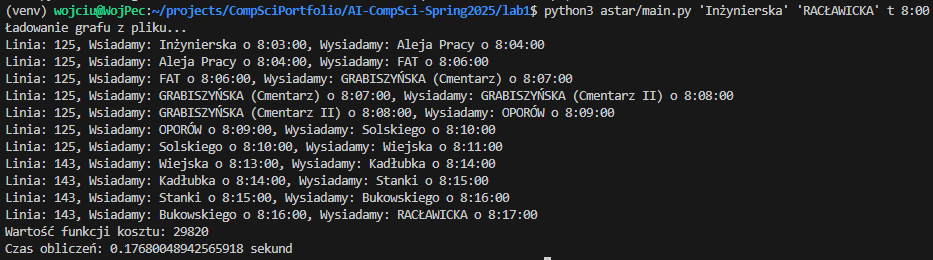

Tabu, wariacja a, przykład zapytania wczytującego serializowany graf. Czas wykonania approx. 6.4146 s

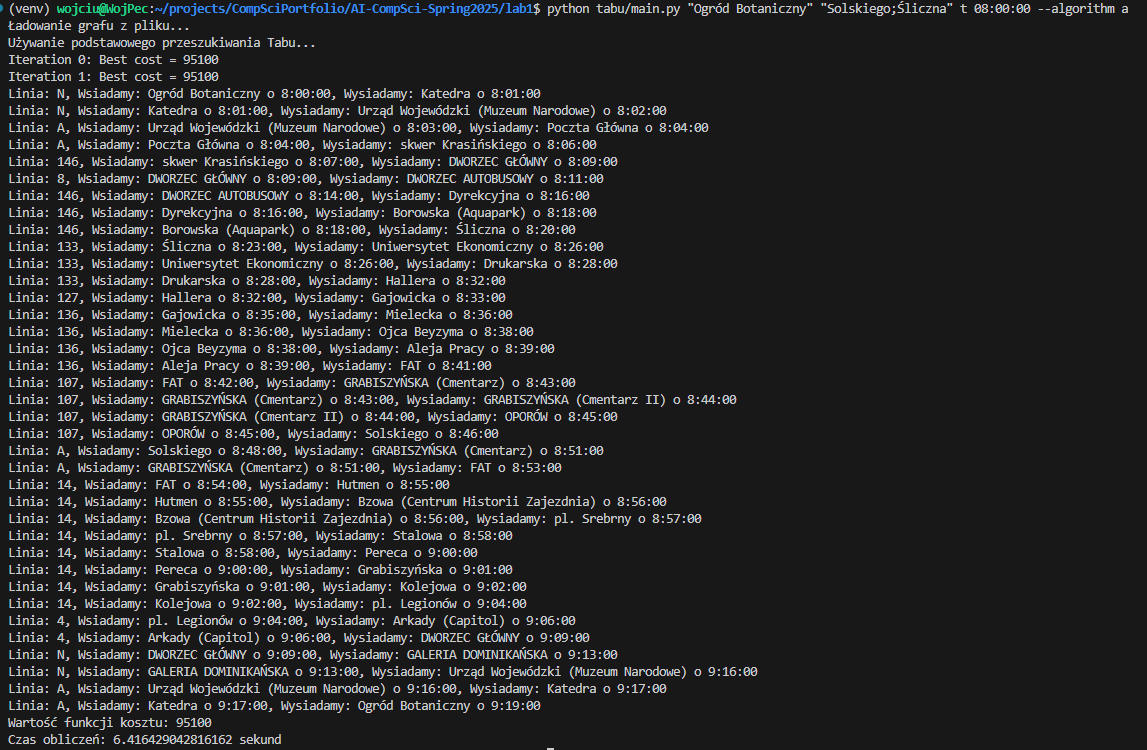

Tabu, wariacja b, przykład zapytania wczytującego serializowany graf. Czas wykonania approx. 4.3298 s. 

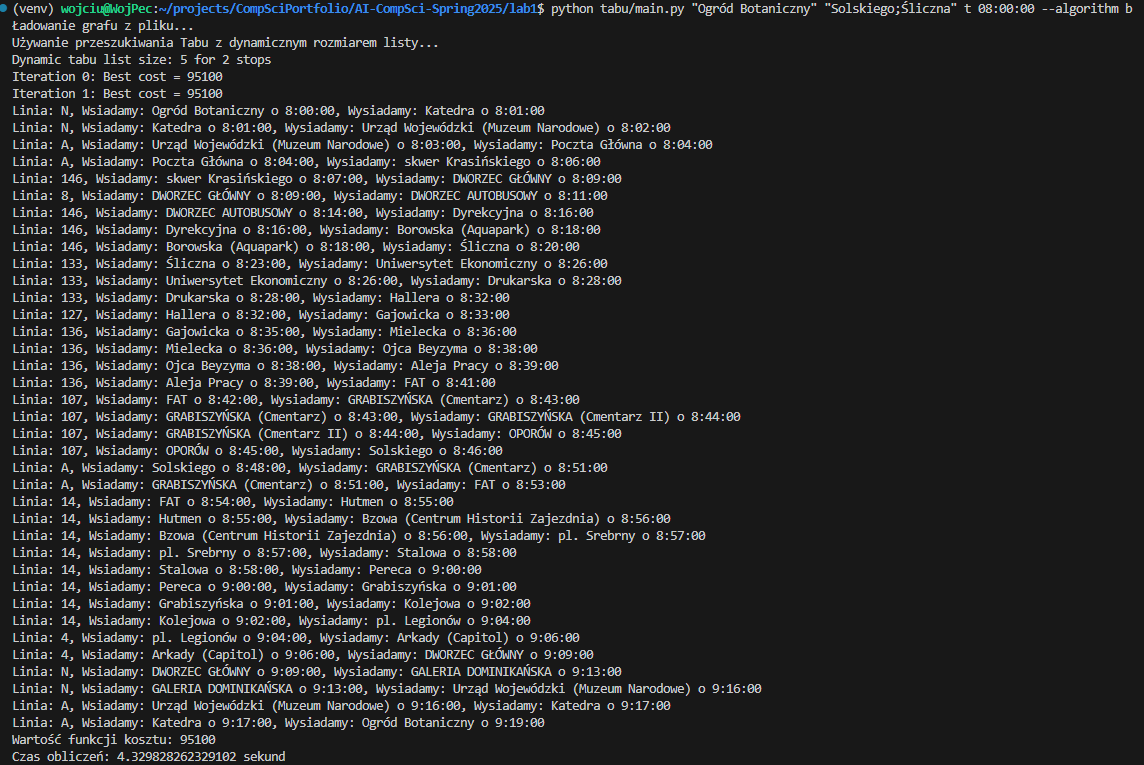

Tabu, wariacja c, przykład zapytania wczytującego serializowany graf. Czas wykonania approx. 6.0976 s. Co martwiące, teoretyczna poprawa funckjonalności zgodna z podpunktem c zdaje się spowalniać czas wykonywania algorytmu z tym samym ksoztem, co wariacja b algorytmu. Niestety, autor nie był w stanie ustalić źródła tego problemu. Wielokrotnie porównano obydwa algorytmy i ich czasy wykonania. Za każdym razem wariacja b algorytmu okazywała się być wydajniejsza. 

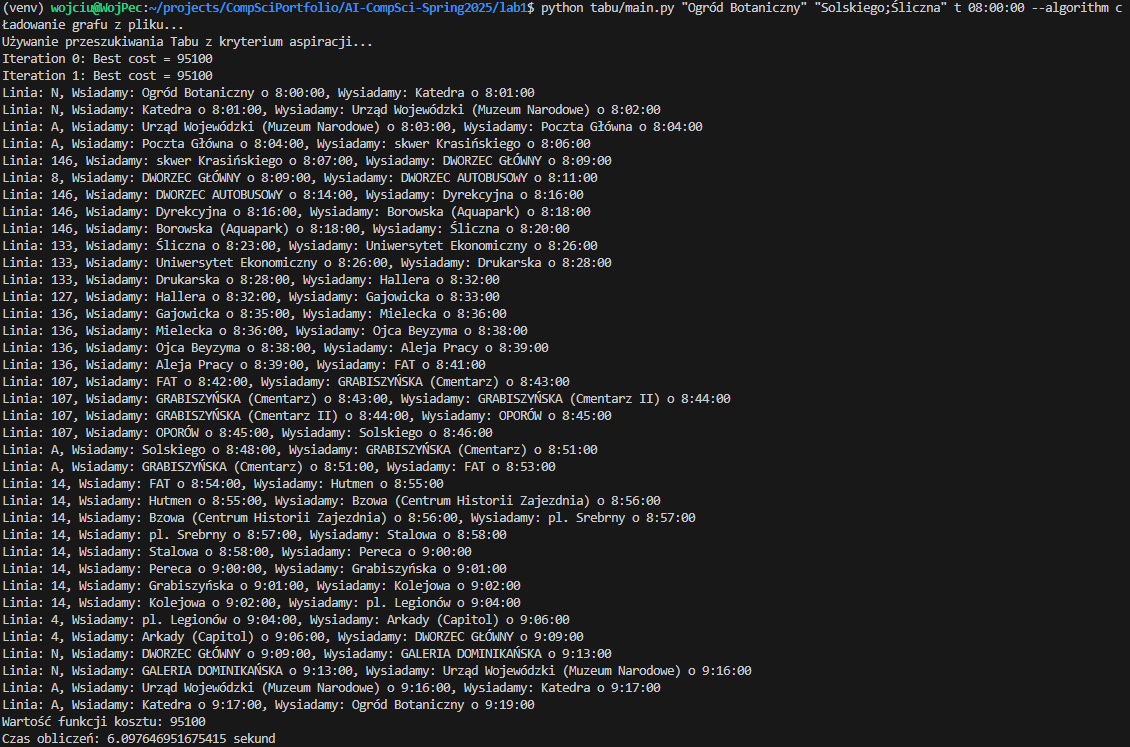

Udana próba zblizenia do wyniku wariacji b.

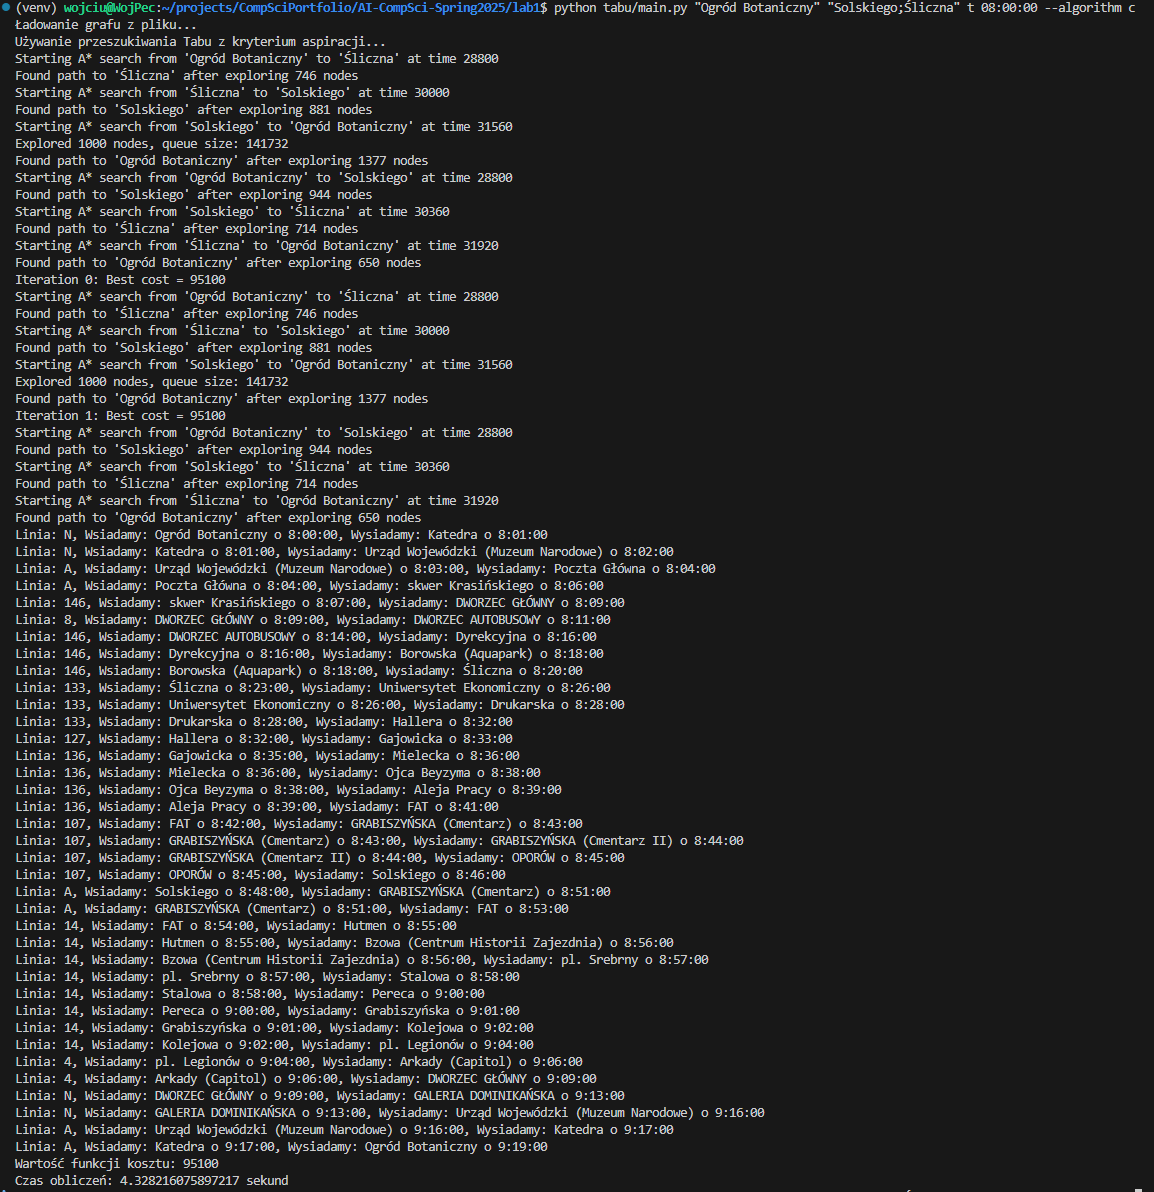

## Refleksje i uwagi
### Refleksje

**Użycie Jupyter Notebook było późną decyzją w procesie opracowywania listy.** Początkowo, był to Microsoft Word, natomiast okazał się on być niepraktyczny do pracy z kodem. Ogólna zmiana narzędzia na obecne oceniana jest pozytywnie, jednakże wynikł z niej dosyć widoczny problem: autor nie ma doświadczenai ze środowiskiem Jupyter Notebook, co było powodem rozdzielenia raportu od kodu. Można zauważyć, że po części jest to sprzeczne z ideą używania tego narzędzia. Przyszłościowo, taką decyzję warto podjąć przy rozpoczynaniu raportu.

**Bardzo pozytywnie na komfort pracy wpłynęło użycie**, już parokrotnie, wspomnianej **biblioteki pickle**. Skrócenie czasu oczekiwania na wynik o 90 sekund zaoszczędziło nawet do 10 godzin pracy nad raportem. Sama implementacja serializacji trwała w granicach 2 godzin. Z pomocą Claude 3.7 okazało się to być dobrym tropem.

**Złym szlakiem była implementacja grafu.** Przy kolejnych raportach do tych celów będą wykorzystywane gotowe biblioteki. Jego implementacja pochłonęła ok. 5 godzin i musiała być wsparta przez Claude 3.7 przez brak wystarczającej wiedzy i doświadczenia. Można założyć, że ta implementacja końcowo przyspieszyła działanie algorytmu.

### Uwagi
Do opracowania listy zostały użyte trzy modele językowe wraz z ich serwisami:
1. PLLuM - poprawność gramatyczna, składnia
2. Perplexity - poszukiwania informacji i cytowań
3. Claude 3.7 - pomoc w zakresie kompetencji technicznych

### Źródła
[The hidden beauty of the A* algorithm](https://www.youtube.com/watch?v=A60q6dcoCjw)

[17. AI using Python- Tabu Search by Sunil Sir](https://www.youtube.com/watch?v=SK3oQ4VI1TM)

[Repozytorium 'transport-network-analysis'](https://github.com/nhabbash/transport-network-analysis?utm_source=chatgpt.com)